In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import imageio

In [2]:
#this connects your google drive to the colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#the model I used is from this resource: https://www.ritchievink.com/blog/2018/07/16/generative-adversarial-networks-in-pytorch-the-distribution-of-art/
#I only altered the batch size and messed around with the random number generation and number of epochs, otherwise the model worked so wellI did not want to adjust anything.
class Discriminator(nn.Module):
    def __init__(self, alpha=0.2):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        if self.training:
            return x
        
        return F.sigmoid(x)

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size=200, alpha=0.2):
        super(Generator, self).__init__()       
        kernel_size = 4
        padding = 1
        stride = 2
        
        self.input = nn.Linear(input_size, 4 * 4 * 1024)
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
            nn.Tanh()
        )
  
    def forward(self, z):
        x = self.input(z)
        return self.net(x.view(-1, 1024, 4, 4))

In [0]:
class ImageFolderEX(datasets.ImageFolder):
    def __getitem__(self, index):
        def get_img(index):
            path, label = self.imgs[index]
            try:
                img = self.loader(os.path.join(self.root, path))
            except:
                img = get_img(index + 1)
            return img
        img = get_img(index)
        return self.transform(img) * 2 - 1  # rescale 0 - 1 to -1 - 1
trans = transforms.Compose([
    transforms.Resize((256, 256), interpolation=2), 
    transforms.ToTensor(), # implicitly normalizes the input to values between 0 - 1.
])


# example showing how to use this helper object. 
#data = torch.utils.data.DataLoader(ImageFolderEX('/content/gdrive/My Drive/256x256/', trans), 
#	batch_size=64, shuffle=True, drop_last=True, num_workers=0)
#x = next(iter(data))

In [0]:
def train_dis(dis, gen, x):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)

    if next(gen.parameters()).is_cuda:
        x = x.cuda()
        z = z.cuda()

    dis.zero_grad()
    y_real_pred = dis(x)
    
    idx = np.random.uniform(0, 1, y_real_pred.shape)
    idx = np.argwhere(idx < 0.03)
    
    # swap some labels and smooth the labels
    ones = np.ones(y_real_pred.shape) + np.random.uniform(-0.1, 0.1)
    ones[idx] = 0
    
    zeros = np.zeros(y_real_pred.shape) + np.random.uniform(0, 0.2)
    zeros[idx] = 1
    ones = torch.from_numpy(ones).float()
    zeros = torch.from_numpy(zeros).float()

    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()
        zeros = zeros.cuda()

    loss_real = F.binary_cross_entropy_with_logits(y_real_pred, ones)

    generated = gen(z)
    y_fake_pred = dis(generated)

    loss_fake = F.binary_cross_entropy_with_logits(y_fake_pred, zeros)
    loss = loss_fake + loss_real
    loss.backward()
    optimizer_dis.step()
    return loss

            
def train_gen(gen, batch_size):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
    
    if next(gen.parameters()).is_cuda:
        z = z.cuda()
    
    gen.zero_grad()
    generated = gen(z)
    y_fake = dis(generated)

    ones = torch.ones_like(y_fake)
    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()

    loss = F.binary_cross_entropy_with_logits(y_fake, ones)
    loss.backward()
    optimizer_gen.step()
    return loss, generated

In [7]:
dis = Discriminator().cuda()
gen = Generator().cuda()

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
optimizer_gen = torch.optim.Adam(gen.parameters(), lr, betas=(beta_1, beta_2))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr, betas=(beta_1, beta_2))

epochs = 20
batch_size = 8
data = torch.utils.data.DataLoader(ImageFolderEX('path_to_folder_containing_the_folder_of_input_data', trans), 
				   batch_size=batch_size, shuffle=True, 
				   drop_last=True, num_workers=2)

n = len(data)
for epoch in range(0, epochs):
    c = 0
    n = len(data) 

    for x in iter(data): 
        c += 1

        loss_dis = train_dis(dis, gen, x)
        loss_gen, generated = train_gen(gen, batch_size)
        
        global_step = epoch * n + c

        if c % 4 == 0:
            print(f'loss: {loss_dis.item()}, \t {loss_gen.item()} \t epoch: {epoch}, \t {c}/{n}')
            

loss: 3.10739803314209, 	 10.657365798950195 	 epoch: 0, 	 4/149
loss: 1.4249818325042725, 	 10.24118423461914 	 epoch: 0, 	 8/149
loss: 0.4270115792751312, 	 13.265869140625 	 epoch: 0, 	 12/149
loss: 1.5428177118301392, 	 2.401353597640991 	 epoch: 0, 	 16/149
loss: 0.3260476589202881, 	 2.3727545738220215 	 epoch: 0, 	 20/149
loss: 0.8049432039260864, 	 10.519817352294922 	 epoch: 0, 	 24/149
loss: 5.040299415588379, 	 5.373712539672852 	 epoch: 0, 	 28/149
loss: 1.0878757238388062, 	 1.9058701992034912 	 epoch: 0, 	 32/149
loss: 1.2154299020767212, 	 8.582995414733887 	 epoch: 0, 	 36/149
loss: 1.128046989440918, 	 3.7046761512756348 	 epoch: 0, 	 40/149
loss: 0.6332927346229553, 	 2.4375314712524414 	 epoch: 0, 	 44/149
loss: 0.3515359163284302, 	 4.222764015197754 	 epoch: 0, 	 48/149
loss: 1.2650282382965088, 	 0.9049816131591797 	 epoch: 0, 	 52/149
loss: 0.42177653312683105, 	 2.670572519302368 	 epoch: 0, 	 56/149
loss: 0.6602201461791992, 	 3.428671360015869 	 epoch: 0, 	 60

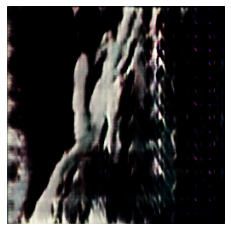

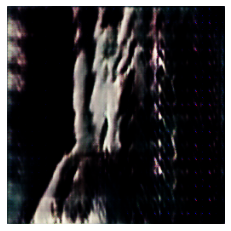

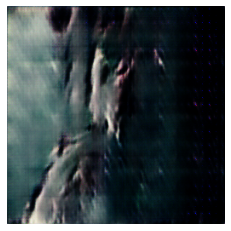

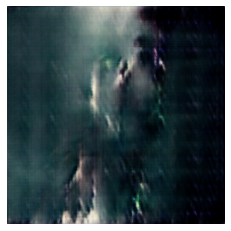

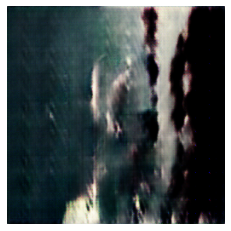

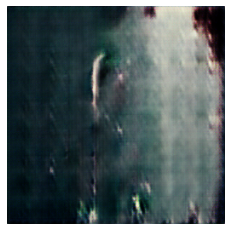

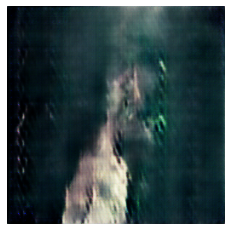

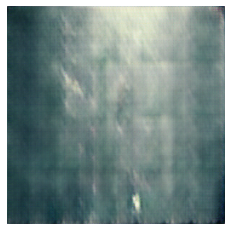

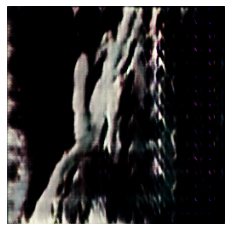

In [23]:
#here I am generating 8 random tensors to input in the trained generator
x1 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x2 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x3 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x4 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x5 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x6 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x7 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
x8 = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)

#Preview the randomly generated images by inputting tensors to generator
sett = [x1,x2,x3,x4,x5,x6,x7,x8,x1]
for i in sett:
  img2 = gen(i.cuda())
  img2 = img2.cpu().detach().numpy()[0]
  img2 = np.transpose(img2, (1,2,0))
  img2 = np.uint8(np.interp(img2, (-1, 1), (0, 255)))
  plt.imshow(img2)
  plt.axis("off")
  plt.show()

In [0]:
#I wrote this bit exploring the latent space by linspacing the randomly generated input tensors

latentspace = []

#here you can choose the order in which you want the images to appear in the interpolation video
#for example
sett = [x6,x3,x8,x2,x4,x5,x1,x7,x6]

#this generates the interpolated frames, I used a linear interpolation for this project
#frames decides the number of images between two initial tensors
frames = 100
for p in range(len(sett)-1):
  for k in range(frames):
    latent = sett[p].clone()
    for c in range(8):
      for i in range(200):
        newvalue = np.linspace(sett[p][c][i], sett[p+1][c][i],frames)[k]
        latent[c][i] = newvalue
    img2 = gen(latent.cuda())
    img2 = img2.cpu().detach().numpy()[0]
    img2 = np.transpose(img2, (1,2,0))
    img2 = np.uint8(np.interp(img2, (-1, 1), (0, 255)))
    latentspace.append(img2)


In [0]:
#this cell combines the generated latent space images into a video file
imageio.mimwrite("your-video-filename.mp4", latentspace , fps = 30)